# Курсовой проект для курса "Python для Data Science"


Материалы к проекту (файлы):
* train.csv
* test.csv


Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import functools as ft
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def val_to_index(val, sr):
    """
    Возвращает индекс ind элемента из gr наиболее с наиболее близким значением к val 
    """
    return ft.reduce((lambda ind, e: sr.index[e[0]] if abs(e[1] - val) < abs(sr[ind] - val) else ind), 
                     enumerate(sr), sr.index[0])

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # Что делает функция?
    
    # Parameters

    # Returns

    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

# Шаг 1. Загрузка данных

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, ',')
df_train = reduce_mem_usage(df_train)
df_train.head(5)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [7]:
df_test = pd.read_csv(TEST_DATASET_PATH, ',')
df_test = reduce_mem_usage(df_test)
df_test.head(5)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [9]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [10]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449501,36.158760,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,4832.674037,44.179466,0.838587,19.092793,17.825277,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [11]:
df_all = pd.concat([df_train.loc[:, df_test.columns], df_test], axis=0)
df_all.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.0000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000
mean,8393.136933,50.693600,1.897000,56.360546,36.851711,6.174467,8.561800,12.6066,3.321575e+03,0.119195,24.769267,5370.404933,8.113667,1144.162476,1.319467,4.235133
std,4850.111673,43.786257,0.839272,20.423899,71.120201,24.017548,5.323113,6.7803,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.307373,1.489012,4.796545
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.0000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4188.750000,20.000000,1.000000,41.814370,22.896130,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8378.500000,37.000000,2.000000,52.645758,32.822811,6.000000,7.000000,12.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12594.250000,75.000000,2.000000,66.036606,45.144627,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.000000,212.000000,19.000000,641.065186,7480.592285,2014.000000,78.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


# Шаг 2. EDA и очистка данных

## 2.1 Распределение целевой переменной

In [12]:
target_name = 'Price'

## 2.2 Анализ признаков

### 2.2.1 Количественные признаки

### 2.2.1.1 Rooms - количество комнат

In [13]:
def chng_0rooms(df, gr):
    """В записях в которых нулевое кол-во комнат, но есть площадь кухни и общая площадь больше жилой на 20%, 
    заменяет кол-во комнат на близкое по общей площади"""
    msk = (df['Rooms'] == 0) & (df['KitchenSquare'] > 0.1) & (df['Square'] * 0.8 > df['LifeSquare'])
    df.loc[msk, 'Rooms'] = df.loc[msk,'Square'].apply(lambda x: val_to_index(x, sr=gr))

    
def chng_lot_rooms(df, mx, gr):
    """В записях в которых кол-во комнат больше mx,  
    заменяет кол-во комнат на близкое по общей площади"""
    msk = df['Rooms'] > mx 
    df.loc[msk, 'Rooms'] = df.loc[msk,'Square'].apply(lambda x: val_to_index(x, sr=gr))

Определим медианное значение Square (общей площади) для каждого количества комнат

In [14]:
gr_rms_train = df_train.groupby(['Rooms'])['Square'].median()
gr_rms_train

Rooms
0.0      65.487473
1.0      40.406590
2.0      55.841812
3.0      77.413643
4.0      98.668060
5.0     116.084862
6.0      59.414333
10.0     59.964119
19.0     42.006046
Name: Square, dtype: float32

Для 0, 6, 10, 19 комнат выборка содержит странные значения, посмотрим записи для 0 комнат

In [15]:
df_train.loc[df_train['Rooms'] == 0,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000
1981,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
2269,7317,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
4366,456,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
8834,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875


В записях в которых есть площадь кухни и общая площадь больше жилой на 20%, поменяем кол-во комнат на близкое по общей площади

In [16]:
chng_0rooms(df_train, gr_rms_train[1.0:5.0])
df_train.loc[[6149],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6149,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375


Посмотрим записи для 6, 10 и 19 комнат

In [17]:
df_train.loc[df_train['Rooms'] > 5,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
1454,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
2170,14003,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750
8849,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625


Заменим на количество комнат близкое по общей площади

In [18]:
chng_lot_rooms(df_train, 5, gr_rms_train[1.0:5.0])
df_train.loc[[377, 1454, 2170, 8849],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,2.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
1454,8491,1,1.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
2170,14003,99,2.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750
8849,14865,9,2.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625


Повторим для тестовой выборки

In [19]:
gr_rms_test = df_test.groupby(['Rooms'])['Square'].median()
gr_rms_test

Rooms
0.0      96.584679
1.0      40.117687
2.0      55.828079
3.0      77.679276
4.0      95.144241
5.0     120.330727
6.0     167.101959
17.0     52.866108
Name: Square, dtype: float32

Для 0, 17 комнат выборка содержит странные значения, посмотрим записи для 0 комнат

In [20]:
df_test.loc[df_test['Rooms'] == 0,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824203,113.692421,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0.0,76.345154,42.820797,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [21]:
chng_0rooms(df_test, gr_rms_test[1.0:6.0])
df_test.loc[[2524],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2524,10729,27,3.0,76.345154,42.820797,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


Посмотрим записи для 17 комнат

In [22]:
df_test.loc[df_test['Rooms'] > 6,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3398,1435,111,17.0,52.866108,32.528343,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [23]:
chng_lot_rooms(df_test, 6, gr_rms_test[1.0:6.0])
df_train.loc[[3398],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3398,8371,57,2.0,54.470478,34.968624,10.0,7,12.0,1978,0.133215,B,B,49,11395,3,1406.0,3,4,A,205198.15625


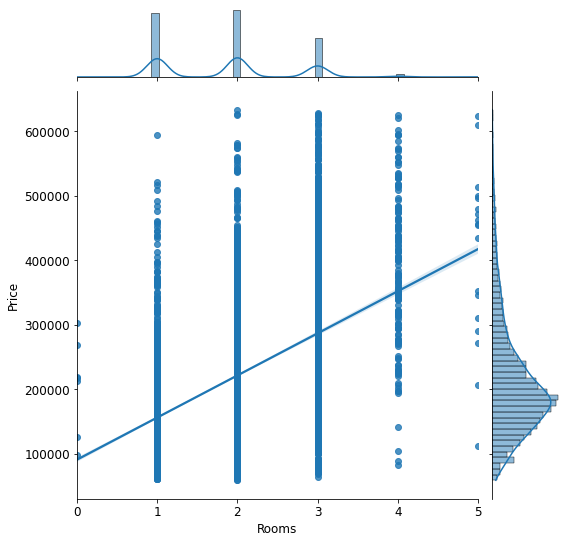

In [24]:
grid = sns.jointplot(df_train['Rooms'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### 2.2.1.2 Square - площадь

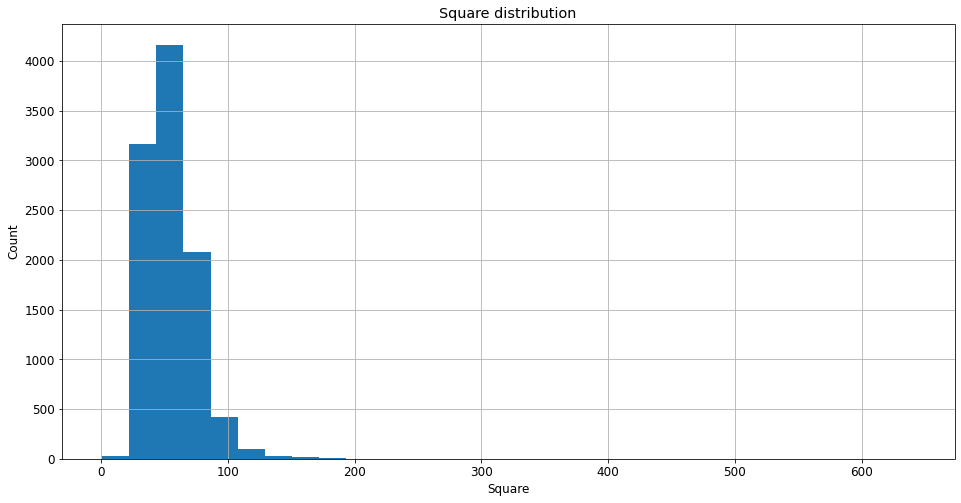

In [25]:
plt.figure(figsize = (16, 8))

df_train['Square'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Square')

plt.title('Square distribution')
plt.show()

Записи с наименьшими значениями общей площади

In [26]:
df_train.loc[df_train['Square'] < 10,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.093750
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.593750
3280,10527,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.718750
3413,9487,5,1.0,5.129221,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.406250
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.062500
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125
8030,13265,1,3.0,4.823679,79.767967,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.687500
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.781250


Найдем медианное соотношение жилой и общей площадей для разного кол-ва комнат

In [27]:
gr_rms_rat_train = df_train.loc[df_train['LifeSquare'].notnull()].groupby('Rooms')
gr_rms_rat_train = gr_rms_rat_train.agg({'Square': 'median', 'LifeSquare': 'median'})
gr_rms_rat_train['ratio'] = gr_rms_rat_train['LifeSquare'] / gr_rms_rat_train['Square']
gr_rms_rat_train = gr_rms_rat_train['ratio']
gr_rms_rat_train

Rooms
0.0    0.978561
1.0    0.546906
2.0    0.605231
3.0    0.619841
4.0    0.660124
5.0    0.693104
Name: ratio, dtype: float32

Восстановим общую площадь на основании жилдой по тем записям где жилая площадь болше 10

In [28]:
def chng_small_sqr(df, gr):
    msk = (df['Square'] < 10) & (df['LifeSquare'] > 10)
    df.loc[msk, 'Square'] = df.loc[msk, 'LifeSquare'] / df.loc[msk, 'Rooms'].apply(lambda x: gr[x])

                                   
chng_small_sqr(df_train, gr_rms_rat_train)
df_train.loc[[212, 3280, 8030],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,111.740395,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.09375
3280,10527,27,1.0,74.612129,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.71875
8030,13265,1,3.0,128.691101,79.767967,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.68750


Остальные посчитаем как медианные по кол-ву комнат

In [29]:
def chng_small_sqr2(df, gr):
    msk = df['Square'] < 10
    df.loc[msk, 'Square'] = df.loc[msk, 'Rooms'].apply(lambda x: gr[x])

                                   
chng_small_sqr2(df_train, gr_rms_train)
df_train.loc[[1316, 1608, 3413, 4853, 4900, 6392, 8283, 9294, 9613],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1316,11526,27,1.0,40.406590,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625
1608,10202,6,1.0,40.406590,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.593750
3413,9487,5,1.0,40.406590,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.406250
4853,3224,27,0.0,65.487473,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
4900,4504,27,3.0,77.413643,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.062500
6392,14786,1,1.0,40.406590,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125
8283,15744,34,1.0,40.406590,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.781250
9294,6782,45,1.0,40.406590,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
9613,7657,38,1.0,40.406590,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.500000


Записи с наибольшими значениями общей площади

In [30]:
df_train.loc[df_train['Square'] >300,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.250000
4690,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
6977,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500


Посчитаем площадь как медианную от кол-ва комнат

In [31]:
def chng_large_sqr(df, gr):
    msk = df['Square'] > 300
    df.loc[msk, 'Square'] = df.loc[msk, 'Rooms'].apply(lambda x: gr[x])

                                   
chng_large_sqr(df_train, gr_rms_train)
df_train.loc[[4262, 4690, 6977],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2.0,55.841812,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.250000
4690,2307,102,1.0,40.406590,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
6977,11602,30,2.0,55.841812,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500


In [32]:
df_test.loc[df_test['Square'] < 10,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
66,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
608,16401,30,1.0,2.645046,4.338756,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
837,2138,27,1.0,5.647459,1.501582,1.0,1,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
1165,10120,6,1.0,5.100671,3.861780,1.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4490,1165,27,1.0,2.372101,1.899119,1.0,2,17.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
4540,7855,6,1.0,4.967143,2.968086,1.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B
4713,170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
4902,1420,45,1.0,1.975769,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B


Повторим для тестовой выборки

In [33]:
gr_rms_rat_test = df_test.loc[df_test['LifeSquare'].notnull()].groupby('Rooms')
gr_rms_rat_test = gr_rms_rat_test.agg({'Square': 'median', 'LifeSquare': 'median'})
gr_rms_rat_test['ratio'] = gr_rms_rat_test['LifeSquare'] / gr_rms_rat_test['Square']
gr_rms_rat_test = gr_rms_rat_test['ratio']
gr_rms_rat_test

Rooms
0.0    0.973192
1.0    0.553383
2.0    0.611312
3.0    0.620143
4.0    0.671498
5.0    0.578082
6.0    0.465929
Name: ratio, dtype: float32

In [34]:
chng_small_sqr(df_test, gr_rms_rat_test)
df_test.loc[[4713],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4713,170,6,2.0,100.551903,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


In [35]:
chng_small_sqr2(df_test, gr_rms_test)
df_test.loc[[66, 608, 837, 1165, 4490, 4540, 4902],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
66,9011,53,1.0,40.117687,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
608,16401,30,1.0,40.117687,4.338756,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
837,2138,27,1.0,40.117687,1.501582,1.0,1,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
1165,10120,6,1.0,40.117687,3.861780,1.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4490,1165,27,1.0,40.117687,1.899119,1.0,2,17.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
4540,7855,6,1.0,40.117687,2.968086,1.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B
4902,1420,45,1.0,40.117687,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B


In [36]:
df_test.loc[df_test['Square'] >200,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3217,4058,27,6.0,223.453690,104.113556,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3909,1397,76,3.0,221.138763,118.055344,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B


Выглядят нормально

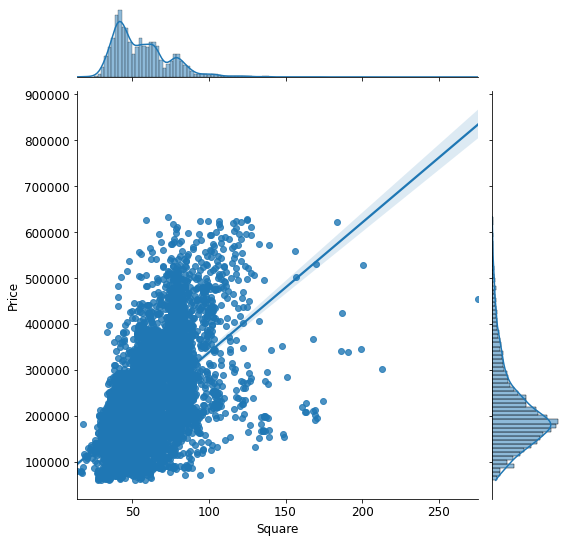

In [37]:
grid = sns.jointplot(df_train['Square'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### 2.2.1.3 KitchenSquare - площадь кухни

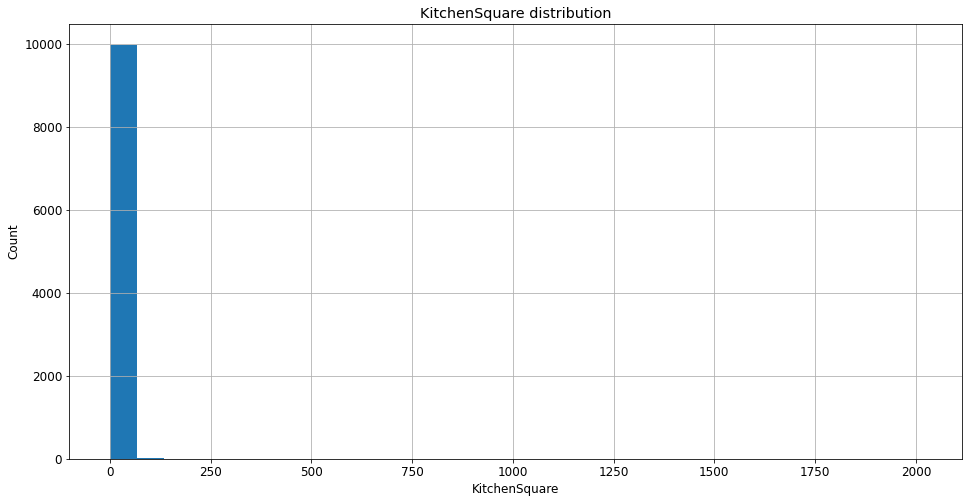

In [38]:
plt.figure(figsize = (16, 8))

df_train['KitchenSquare'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('KitchenSquare')

plt.title('KitchenSquare distribution')
plt.show()

Записи с наименьшими значениями площади кухни

In [39]:
df_train.loc[(df_train['KitchenSquare'] < 2) & (df_train['Rooms'] > 0),]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
7,11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
8,5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875
12,6452,13,2.0,54.522804,31.759752,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.375000
14,10953,27,1.0,53.769096,52.408028,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9986,2996,1,2.0,64.994247,NaN,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625
9987,15623,23,2.0,55.620090,NaN,0.0,2,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688
9994,4158,23,2.0,64.864197,NaN,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625


In [40]:
gr_rms_ktch_train = df_train.groupby(['Rooms'])['KitchenSquare'].median()
gr_rms_ktch_train

Rooms
0.0    0.0
1.0    6.0
2.0    6.0
3.0    7.0
4.0    9.0
5.0    9.0
Name: KitchenSquare, dtype: float32

In [41]:
def chng_small_ktch(df, gr):
    msk = (df['KitchenSquare'] < 2) & (df['Rooms'] > 0)
    df.loc[msk, 'KitchenSquare'] = df.loc[msk, 'Rooms'].apply(lambda x: gr[x])

                                   
chng_small_ktch(df_train, gr_rms_ktch_train)
df_train.loc[[2, 14, 9997],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.90625
14,10953,27,1.0,53.769096,52.408028,6.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.56250
9997,5123,27,1.0,47.939007,NaN,6.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.81250


Записи с наибольшими значениями площади кухни

In [42]:
msk = (df_train['KitchenSquare'] > 20) & (df_train['KitchenSquare'] > df_train['Square'] * 0.5)
df_train.loc[msk,].head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722244,44.731220,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625000
551,1315,6,1.0,48.128113,45.023533,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.906250
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375
1077,9690,27,1.0,40.081043,37.834965,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.648438
1369,2371,27,2.0,68.841072,64.234955,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.250000


заменим на медианное значение от кол-ва комнат

In [43]:
def change_column_srs(df, msk, chng_clmn, key_clmn, sr):
    """Замена значений в столбце chng_clmn в датафрейме df в строка выбранных по маске msk на значение в sr по ключу key_clmn"""
    df.loc[msk, chng_clmn] = df.loc[msk, key_clmn].apply(lambda x: sr[x])

    
change_column_srs(df_train, msk, 'KitchenSquare', 'Rooms', gr_rms_ktch_train)
df_train.loc[[1064, 1455, 4651],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,6.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375
1455,12507,54,2.0,79.810532,79.578964,6.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.718750
4651,12552,58,3.0,116.405693,113.109650,7.0,3,3.0,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.937500


Повторим для тестовой выборки

In [44]:
msk = (df_test['KitchenSquare'] < 2) & (df_test['Rooms'] > 0)
df_test.loc[msk,].head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1.0,40.675625,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2.0,68.099541,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
11,3310,6,3.0,84.625351,NaN,1.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B


In [45]:
gr_rms_ktch_test = df_test.groupby(['Rooms'])['KitchenSquare'].median()
gr_rms_ktch_test

Rooms
0.0    0.0
1.0    6.0
2.0    6.0
3.0    7.0
4.0    8.0
5.0    8.0
6.0    8.0
Name: KitchenSquare, dtype: float32

In [46]:
change_column_srs(df_test, msk, 'KitchenSquare', 'Rooms', gr_rms_ktch_test)
df_test.loc[[1, 4, 11, 4987],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263184,NaN,6.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
11,3310,6,3.0,84.625351,NaN,7.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4987,5361,53,3.0,80.102104,NaN,7.0,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B


In [47]:
msk = (df_test['KitchenSquare'] > 20) & (df_test['KitchenSquare'] > df_test['Square'] * 0.5)
df_test.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
40,5428,27,2.0,62.326042,NaN,61.0,12,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
1456,5260,73,3.0,69.358246,51.247581,65.0,6,6.0,1931,0.042032,B,B,37,6856,84,1940.0,2,5,B
1777,3341,62,3.0,112.114021,112.247841,112.0,3,3.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
1964,14594,11,2.0,42.795303,24.223770,620.0,11,14.0,1972,0.038693,B,B,28,6533,1,1015.0,2,5,B
2424,10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,B,B,31,6119,4,NaN,1,2,B
3723,4483,62,1.0,41.951462,45.672138,41.0,13,17.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A
3816,12612,27,2.0,60.988495,33.646725,60.0,5,17.0,2013,0.072158,B,B,2,629,1,NaN,0,0,A
3863,3194,29,2.0,43.926987,31.028708,44.0,6,5.0,1964,0.086885,B,B,10,2277,2,1547.0,0,0,B
3927,6568,78,1.0,46.827202,40.227013,40.0,5,32.0,2007,0.219006,B,B,28,6746,3,NaN,1,4,B
4281,8015,27,1.0,66.099098,33.639610,62.0,3,7.0,2016,0.014058,B,B,1,290,0,NaN,0,0,B


In [48]:
change_column_srs(df_test, msk, 'KitchenSquare', 'Rooms', gr_rms_ktch_test)
df_test.loc[[40, 1456, 1777, 2424],]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
40,5428,27,2.0,62.326042,NaN,6.0,12,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
1456,5260,73,3.0,69.358246,51.247581,7.0,6,6.0,1931,0.042032,B,B,37,6856,84,1940.0,2,5,B
1777,3341,62,3.0,112.114021,112.247841,7.0,3,3.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2424,10662,29,1.0,25.956829,17.251768,6.0,5,5.0,1973,0.069660,B,B,31,6119,4,NaN,1,2,B


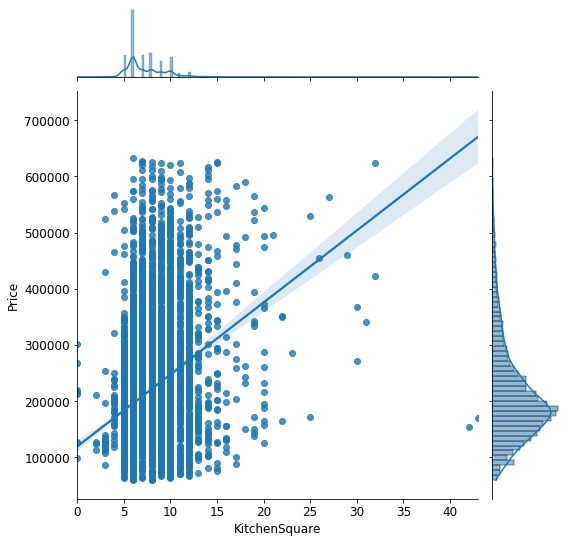

In [49]:
grid = sns.jointplot(df_train['KitchenSquare'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### 2.2.1.4 LifeSquare - жилая площадь

Заполним пустые значения как разницу между общей площадью и площадью кухни

In [50]:
msk = df_train['LifeSquare'].isnull()
df_train.loc[msk,'LifeSquare'] = df_train.loc[msk,'Square'] - df_train.loc[msk,'KitchenSquare']

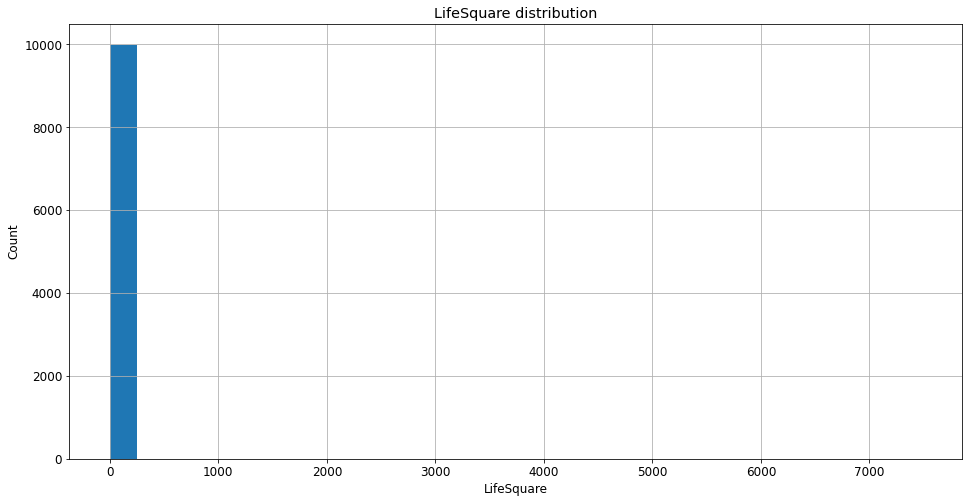

In [51]:
plt.figure(figsize = (16, 8))

df_train['LifeSquare'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('LifeSquare')

plt.title('LifeSquare distribution')
plt.show()

Жилая площадь в три раза меньше чем разница между общей площадью и кухней

In [52]:
msk = df_train['LifeSquare'] < (df_train['Square'] - df_train['KitchenSquare']) / 3
df_train.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958870,0.641822,7.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000
95,4280,34,2.0,61.334969,4.091945,6.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.437500
134,12613,6,2.0,65.496674,5.589324,6.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.640625
158,16779,27,3.0,51.991066,4.896202,7.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.562500
160,3522,6,1.0,66.419838,3.987101,6.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.234375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,13583,27,2.0,58.943039,3.319486,6.0,11,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.953125
9813,2040,62,1.0,122.438148,5.751401,6.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.890625
9828,13630,24,3.0,127.141144,4.811405,7.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.937500
9888,6053,6,1.0,41.314774,5.005477,6.0,9,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515625


In [53]:
df_train.loc[msk,'LifeSquare'] = df_train.loc[msk,'Square'] - df_train.loc[msk,'KitchenSquare']

Жилая площадь больше общей площади

In [54]:
msk = df_train['LifeSquare'] > df_train['Square']
df_train.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530045,43.967758,6.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.195312
44,10521,38,3.0,104.211395,106.340401,7.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.062500
52,2301,1,2.0,61.400055,65.224602,6.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.453125
123,8753,25,3.0,85.952309,89.803749,7.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.593750
153,9870,62,1.0,51.831474,53.491302,6.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2.0,59.015896,59.439083,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.140625
9889,12918,23,2.0,51.440464,53.134243,6.0,3,17.0,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.015625
9895,2737,27,3.0,123.430069,125.806984,7.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.843750
9902,14001,73,1.0,44.098766,44.267551,6.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.406250


In [55]:
df_train.loc[msk,'LifeSquare'] = df_train.loc[msk,'Square'] - df_train.loc[msk,'KitchenSquare']

Повторим для тестовой выборки

In [56]:
msk = df_test['LifeSquare'].isnull()
df_test.loc[msk,'LifeSquare'] = df_test.loc[msk,'Square'] - df_test.loc[msk,'KitchenSquare']

In [57]:
msk = df_test['LifeSquare'] < (df_test['Square'] - df_test['KitchenSquare']) / 3
df_test.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
18,3495,27,3.0,82.652817,5.690155,7.0,4,17.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
66,9011,53,1.0,40.117687,1.353573,6.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
71,9205,120,2.0,85.911827,4.188396,6.0,5,1.0,2016,0.341072,B,B,27,5664,48,2300.0,3,11,B
77,7034,45,2.0,59.927502,3.798341,6.0,23,1.0,2017,0.195781,B,B,23,5212,6,NaN,3,2,B
78,6553,34,5.0,122.375275,0.333490,8.0,9,0.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,8963,27,3.0,79.114388,3.329216,7.0,3,22.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
4846,5002,1,3.0,82.624840,4.379317,7.0,5,17.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B
4863,4611,27,2.0,76.709541,2.989508,6.0,13,12.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A
4902,1420,45,1.0,40.117687,2.900371,6.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B


In [58]:
df_test.loc[msk,'LifeSquare'] = df_test.loc[msk,'Square'] - df_test.loc[msk,'KitchenSquare']

In [59]:
msk = df_test['LifeSquare'] > df_test['Square']
df_test.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
27,11160,58,1.0,48.610661,48.752502,6.0,4,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
39,6624,27,1.0,42.413792,42.434887,10.0,12,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B
43,11513,1,1.0,37.484058,40.593037,6.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
70,1872,30,2.0,52.449059,52.798351,6.0,17,17.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4927,14686,1,3.0,77.229889,79.958687,7.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4951,3711,94,1.0,41.281055,42.392593,10.0,13,13.0,2014,0.282798,B,B,33,8667,2,NaN,0,6,B
4962,5820,94,1.0,33.680382,34.198978,6.0,10,9.0,1972,0.127376,B,B,43,8429,3,NaN,3,9,B
4969,4821,74,2.0,82.542503,82.585068,6.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B


In [60]:
df_test.loc[msk,'LifeSquare'] = df_test.loc[msk,'Square'] - df_test.loc[msk,'KitchenSquare']

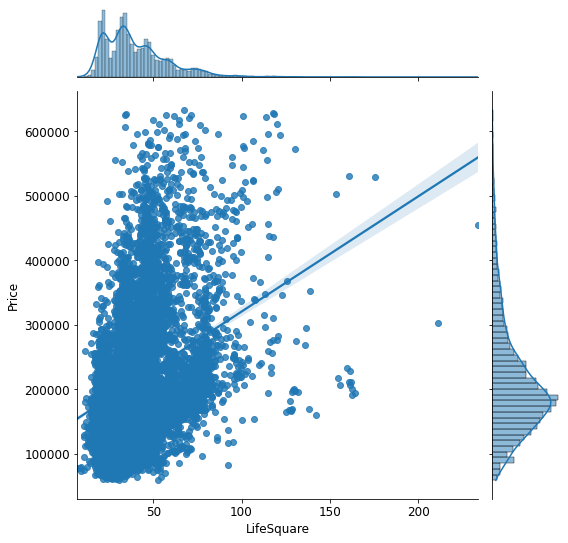

In [61]:
grid = sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### 2.2.1.5 Floor - этаж

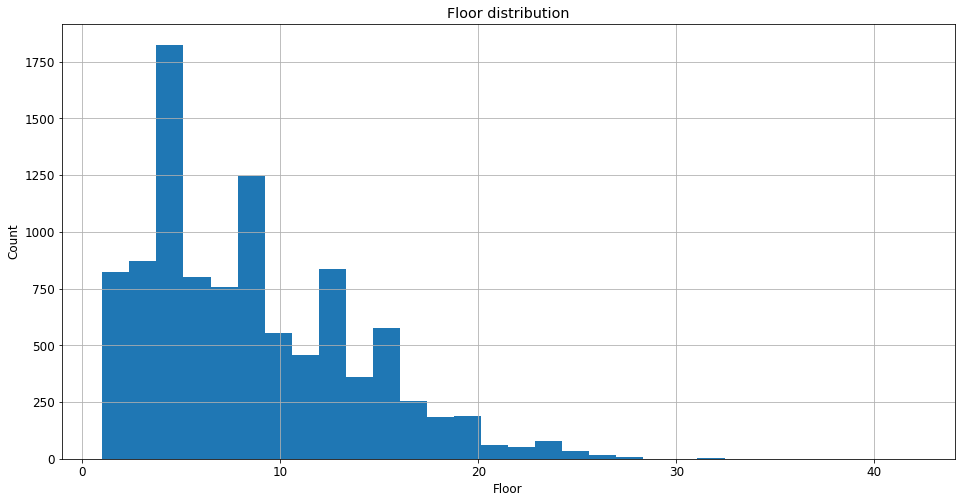

In [62]:
plt.figure(figsize = (16, 8))

df_train['Floor'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Floor')

plt.title('Floor distribution')
plt.show()

Найдем записи где этаж больше этажности дома и заменим на случайное значение от 1 до этажности дома

In [63]:
msk = (df_train['Floor'] > df_train['HouseFloor']) & (df_train['HouseFloor'] > 0)
df_train.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14,10953,27,1.0,53.769096,52.408028,6.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500
16,2119,27,2.0,49.360649,31.993963,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.382812
21,11935,27,2.0,64.711838,58.711838,6.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438
35,6486,200,3.0,85.280388,58.447968,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,NaN,2,5,B,402871.906250
51,10103,94,1.0,35.280895,23.354176,6.0,11,9.0,1971,0.282798,B,B,33,8667,2,NaN,0,6,B,148862.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074974,47.633427,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.875000
9985,16159,27,1.0,38.968338,32.968338,6.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9989,4145,96,3.0,90.055229,47.860229,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,NaN,1,4,B,441108.906250
9991,11553,3,3.0,101.622795,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.500000


In [64]:
df_train.loc[msk, 'Floor'] = df_train.loc[msk, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Повторим для тестовой выборки

In [65]:
msk = (df_test['Floor'] > df_test['HouseFloor']) & (df_test['HouseFloor'] > 0)
df_test.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263184,63.263184,6.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
10,15975,61,3.0,64.543655,42.651543,7.0,10,9.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
14,5214,27,1.0,37.555195,31.555195,6.0,5,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
27,11160,58,1.0,48.610661,42.610661,6.0,4,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
36,9348,205,1.0,37.480812,16.851795,8.0,6,5.0,1933,0.169091,B,B,19,3856,10,NaN,2,5,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,15181,27,4.0,104.664207,66.903564,8.0,4,1.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B
4972,16064,30,1.0,38.376236,37.003311,6.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
4989,2591,39,2.0,44.203590,30.191690,6.0,10,9.0,1972,0.428826,B,B,25,5011,8,730.0,0,2,B
4993,14562,113,2.0,46.627884,27.058739,5.0,6,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B


In [66]:
df_test.loc[msk, 'Floor'] = df_test.loc[msk, 'HouseFloor'].apply(lambda x: random.randint(1, x))

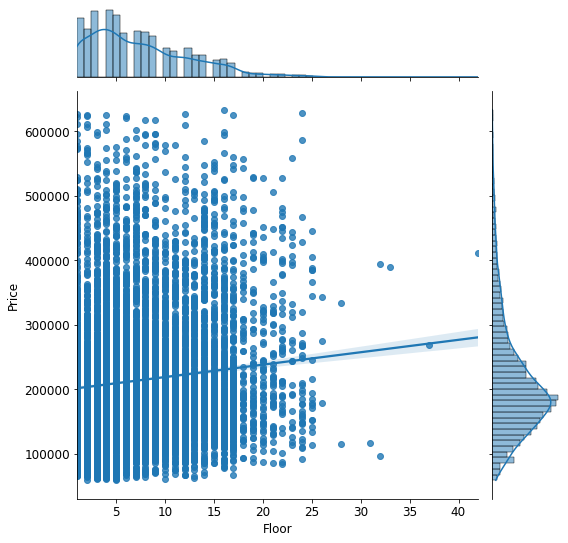

In [67]:
grid = sns.jointplot(df_train['Floor'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### 2.2.1.6 HouseFloor - количество этажей в доме

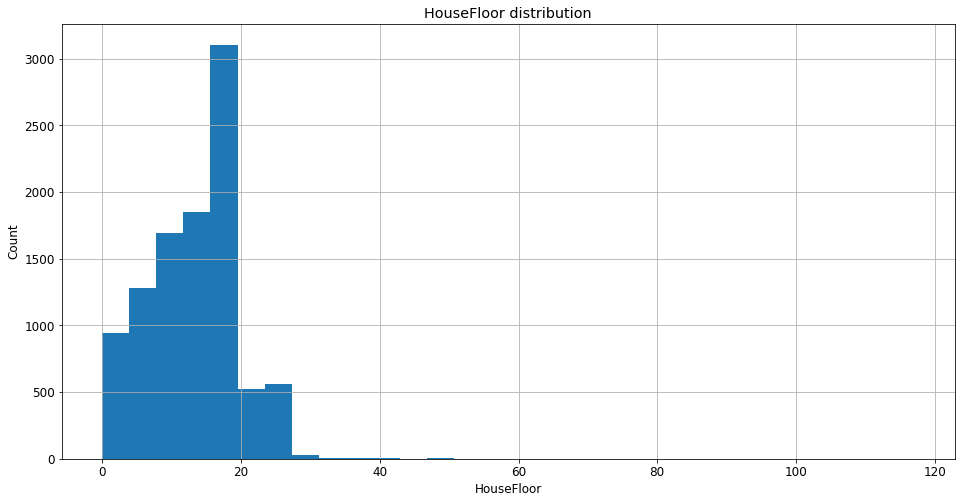

In [68]:
plt.figure(figsize = (16, 8))

df_train['HouseFloor'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('HouseFloor')

plt.title('HouseFloor distribution')
plt.show()

Заменим нулевую этажность в доме на текущий этаж плюс случайная величина от 0 до 10

In [69]:
msk = df_train['HouseFloor'] == 0
df_train.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312927,74.312927,6.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.15625
23,6641,54,3.0,118.907608,111.907608,7.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.06250
26,4378,27,3.0,106.958870,99.958870,7.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.87500
39,9371,23,2.0,60.503250,54.503250,6.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.06250
44,10521,38,3.0,104.211395,97.211395,7.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.06250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,46.072914,40.072914,6.0,4,0.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.09375
9769,9384,59,3.0,98.607330,91.607330,7.0,14,0.0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.25000
9878,11441,62,2.0,71.985336,65.985336,6.0,5,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,158841.62500
9908,3171,62,1.0,35.873962,29.873962,6.0,25,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,134379.12500


In [70]:
df_train.loc[msk, 'HouseFloor'] = df_train.loc[msk, 'Floor'].apply(lambda x: x + random.randint(0, 9))

Повторим для тестовой выборки

In [71]:
msk = df_test['HouseFloor'] == 0
df_test.loc[msk,]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
22,12694,27,3.0,83.670029,46.358356,7.0,8,0.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
24,8968,27,2.0,69.849243,63.849243,6.0,3,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
30,2982,6,2.0,63.460686,57.460686,6.0,13,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
32,2449,1,1.0,66.426582,60.426582,6.0,14,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
46,12309,45,1.0,42.899570,36.899570,6.0,25,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4856,10262,27,2.0,69.196442,63.196442,6.0,10,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
4887,12116,88,3.0,89.549561,82.549561,7.0,20,0.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B
4892,16357,58,1.0,49.205978,43.205978,6.0,4,0.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4976,4723,95,1.0,45.542938,39.542938,6.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B


In [72]:
df_test.loc[msk, 'HouseFloor'] = df_test.loc[msk, 'Floor'].apply(lambda x: x + random.randint(0, 9))

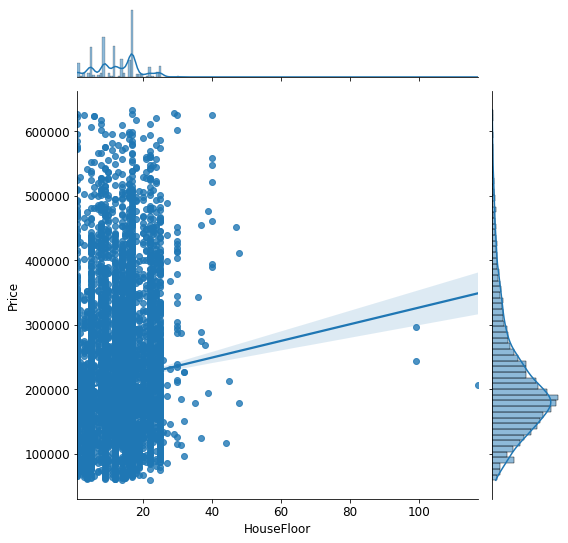

In [73]:
grid = sns.jointplot(df_train['HouseFloor'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### 2.2.1.6 Остальные признаки

По остальным признакам заменим выбросы медианным значением

In [74]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = df_train['HouseYear'].median()
df_test.loc[df_test['HouseYear'] > 2020, 'HouseYear'] = df_test['HouseYear'].median()

In [75]:
df_train.loc[df_train['Social_3'] > 5, 'Social_3'] = df_train['Social_3'].median()
df_test.loc[df_test['Social_3'] > 5, 'Social_3'] = df_test['Social_3'].median()

In [76]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

### 2.2.2 номинативные признаки

In [77]:
df_train['Ecology_2_bin'] = df_train['Ecology_2'].replace({'A':0, 'B':1})
df_train['Ecology_3_bin'] = df_train['Ecology_3'].replace({'A':0, 'B':1})
df_train['Shops_2_bin'] = df_train['Shops_2'].replace({'A':0, 'B':1})

In [78]:
df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A':0, 'B':1})
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A':0, 'B':1})
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A':0, 'B':1})

## 2.3 Создание новых признаков

### 2.3.1 Цена за квадратный метр

In [79]:
dst = df_train['DistrictId'].values
df_test.loc[ df_test['DistrictId'].isin(dst) == False, 'DistrictId'].unique()

array([212, 210, 206, 204, 203, 211, 198], dtype=int16)

In [80]:
df_train['Price_per_metr'] = df_train['Price'] / df_train['Square']

In [81]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price_per_metr
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.886800,56.235058,40.393349,7.423600,7.463700,12.968500,1984.863800,0.118858,...,5352.157400,1.612400,1026.358887,1.319500,4.231300,214139.218750,0.990300,0.972500,0.917500,3892.521240
std,4859.01902,43.587592,0.812683,19.092304,18.657467,2.335307,5.093238,6.522215,18.409979,0.119026,...,4006.799803,1.426313,746.645447,1.493601,4.806341,92872.304688,0.098015,0.163543,0.275139,1255.838989
min,0.00000,0.000000,0.000000,13.784864,6.784864,0.000000,1.000000,1.000000,1910.000000,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,752.588684
25%,4169.50000,20.000000,1.000000,41.783181,27.142732,6.000000,3.000000,9.000000,1974.000000,0.017647,...,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.628906,1.000000,1.000000,1.000000,2916.973694
50%,8394.50000,36.000000,2.000000,52.537977,35.760241,7.000000,6.000000,14.000000,1977.000000,0.075424,...,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438,1.000000,1.000000,1.000000,3907.999878
75%,12592.50000,75.000000,2.000000,65.905352,48.977367,9.000000,11.000000,17.000000,2001.000000,0.195781,...,7227.000000,2.000000,990.000000,2.000000,6.000000,249135.460938,1.000000,1.000000,1.000000,4690.526489
max,16798.00000,209.000000,5.000000,275.645294,233.949310,43.000000,42.000000,117.000000,2020.000000,0.521867,...,19083.000000,5.000000,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,11960.511719


Пересчитаем стоимость, если цена за метр превысила 10000

In [82]:
msk = df_train['Price_per_metr'] > 10000
mdn = df_train['Price_per_metr'].median()
df_train.loc[msk, 'Price_per_metr'] = mdn
df_train.loc[msk, 'Price'] = df_train.loc[msk, 'Square'] * mdn

### 2.3.2 Размер района

In [83]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [84]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price_per_metr,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,900.0,0,11,B,184966.937500,1,1,1,3854.958740,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.437500,1,1,1,4567.491211,87
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,...,229.0,1,3,B,220925.906250,1,1,1,4915.149414,174
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.234375,1,1,1,3291.591797,179
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531250,1,1,1,3788.892578,97


Повторим для тестовой выборки

In [85]:
district_size = df_test['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [86]:
df_test = df_test.merge(district_size, on='DistrictId', how='left')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972.0,0.310199,...,2748,1.0,900.0,0,0,B,1,1,1,91
1,15856,74,2.0,69.263184,63.263184,6.0,1,1.0,1977.0,0.075779,...,1437,3.0,900.0,0,2,B,1,1,1,61
2,5480,190,1.0,13.597818,1.597818,12.0,2,5.0,1909.0,0.000000,...,7538,2.0,4702.0,5,5,B,1,1,1,2
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007.0,0.101872,...,4583,3.0,900.0,3,3,B,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017.0,0.072158,...,629,1.0,900.0,0,0,A,1,1,0,391


### 2.3.2 Признаки певого и последнего этажа 

In [87]:
df_train.loc[(df_train['Floor'] > 0) & (df_train['Floor'] == df_train['HouseFloor']),'LastFloor'] = 1
df_train.loc[df_train['LastFloor'].isnull(),'LastFloor'] = 0
df_train.loc[(df_train['HouseFloor'] > 2) & (df_train['Floor'] == 1),'FirstFloor'] = 1
df_train.loc[df_train['FirstFloor'].isnull(),'FirstFloor'] = 0

In [88]:
df_test.loc[(df_test['Floor'] > 0) & (df_test['Floor'] == df_test['HouseFloor']),'LastFloor'] = 1
df_test.loc[df_test['LastFloor'].isnull(),'LastFloor'] = 0
df_test.loc[(df_test['HouseFloor'] > 2) & (df_test['Floor'] == 1),'FirstFloor'] = 1
df_test.loc[df_test['FirstFloor'].isnull(),'FirstFloor'] = 0

### 2.3.2 Средние цены за квартиры по районам в зависимости от количества комнат

In [89]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median', 'Square' : 'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict', 'Square' :'MedSquareByDistrict'})

med_price_by_district.head(10)

,DistrictId,Rooms,MedPriceByDistrict,MedSquareByDistrict
0,0,1.0,142799.437500,36.158718
1,0,2.0,176210.812500,53.133224
2,0,3.0,300610.375000,79.035431
3,1,1.0,146574.015625,42.496132
4,1,2.0,202706.093750,64.153198
5,1,3.0,244005.281250,81.999115
6,1,4.0,277290.718750,99.893005
7,2,1.0,174545.968750,36.977509
8,2,2.0,215477.281250,47.804619
9,2,3.0,323304.625000,75.427353


In [90]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price_per_metr,DistrictSize,LastFloor,FirstFloor,MedPriceByDistrict,MedSquareByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,184966.937500,1,1,1,3854.958740,22,0.0,0.0,207786.125000,48.115669
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,300009.437500,1,1,1,4567.491211,87,0.0,0.0,300009.437500,70.733223
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,...,220925.906250,1,1,1,4915.149414,174,0.0,0.0,263206.218750,56.803894
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,175616.234375,1,1,1,3291.591797,179,0.0,0.0,166809.671875,61.374363
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,150226.531250,1,1,1,3788.892578,97,0.0,0.0,158539.062500,37.186752


Перенесем значения на тестовую выборку

In [91]:
df_test = df_test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LastFloor,FirstFloor,MedPriceByDistrict,MedSquareByDistrict
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972.0,0.310199,...,0,B,1,1,1,91,0.0,0.0,166809.671875,61.374363
1,15856,74,2.0,69.263184,63.263184,6.0,1,1.0,1977.0,0.075779,...,2,B,1,1,1,61,1.0,0.0,243031.687500,75.412491
2,5480,190,1.0,13.597818,1.597818,12.0,2,5.0,1909.0,0.000000,...,5,B,1,1,1,2,0.0,0.0,NaN,NaN
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007.0,0.101872,...,3,B,1,1,1,49,1.0,0.0,222227.593750,54.881542
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017.0,0.072158,...,0,A,1,1,0,391,1.0,0.0,118327.093750,42.003395


In [92]:
df_test_null = df_test.loc[df_test['MedPriceByDistrict'].isnull(),]
df_test_null

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LastFloor,FirstFloor,MedPriceByDistrict,MedSquareByDistrict
2,5480,190,1.0,13.597818,1.597818,12.0,2,5.0,1909.0,0.000000e+00,...,5,B,1,1,1,2,0.0,0.0,NaN,NaN
51,15748,212,2.0,75.655182,36.877625,15.0,2,7.0,1929.0,0.000000e+00,...,8,B,1,1,1,1,0.0,0.0,NaN,NaN
149,3764,193,4.0,97.931641,72.386902,8.0,5,5.0,1957.0,3.198093e-01,...,8,B,1,1,1,1,1.0,0.0,NaN,NaN
255,10816,51,3.0,97.889336,58.640564,12.0,4,5.0,1929.0,1.501689e-02,...,8,B,1,1,1,8,0.0,0.0,NaN,NaN
263,11407,79,4.0,37.920349,21.357487,6.0,6,17.0,2014.0,3.074667e-01,...,5,B,1,0,1,24,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,2196,52,4.0,104.638512,62.185444,10.0,4,22.0,2005.0,3.711490e-01,...,5,B,1,1,1,67,0.0,0.0,NaN,NaN
4711,429,92,4.0,107.747551,60.377350,13.0,10,17.0,2008.0,4.605564e-01,...,5,B,1,1,1,7,0.0,0.0,NaN,NaN
4719,13426,209,3.0,57.320442,43.187836,6.0,4,5.0,1967.0,4.024277e-02,...,1,B,1,1,1,2,0.0,0.0,NaN,NaN
4725,15237,115,1.0,31.605209,18.247347,5.0,3,5.0,1962.0,1.800000e-09,...,5,B,1,1,1,6,0.0,0.0,NaN,NaN


In [93]:
gr_test_null = df_test_null.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Square' : 'median'})\
                       .rename(columns={'Square' :'MedSquareByDistrictNull'})
med_price_per_metr = df_train['Price_per_metr'].median()
print(med_price_per_metr)
gr_test_null['MedPriceByDistrictNull'] = gr_test_null['MedSquareByDistrictNull'] * med_price_per_metr
gr_test_null.head(10)

3907.77783203125


,DistrictId,Rooms,MedSquareByDistrictNull,MedPriceByDistrictNull
0,0,4.0,107.161346,418762.718750
1,9,5.0,97.537811,381156.093750
2,16,1.0,34.637802,135356.828125
3,19,4.0,102.724968,401426.343750
4,23,6.0,110.750229,432787.281250
5,25,5.0,120.330727,470225.750000
6,27,6.0,223.453690,873207.375000
7,31,4.0,131.786575,514992.656250
8,43,3.0,63.790657,249279.718750
9,43,4.0,90.754036,354646.625000


In [94]:
df_test = df_test.merge(gr_test_null, on=['DistrictId', 'Rooms'], how='left')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LastFloor,FirstFloor,MedPriceByDistrict,MedSquareByDistrict,MedSquareByDistrictNull,MedPriceByDistrictNull
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972.0,0.310199,...,1,1,1,91,0.0,0.0,166809.671875,61.374363,NaN,NaN
1,15856,74,2.0,69.263184,63.263184,6.0,1,1.0,1977.0,0.075779,...,1,1,1,61,1.0,0.0,243031.687500,75.412491,NaN,NaN
2,5480,190,1.0,13.597818,1.597818,12.0,2,5.0,1909.0,0.000000,...,1,1,1,2,0.0,0.0,NaN,NaN,13.597818,53137.253906
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007.0,0.101872,...,1,1,1,49,1.0,0.0,222227.593750,54.881542,NaN,NaN
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017.0,0.072158,...,1,1,0,391,1.0,0.0,118327.093750,42.003395,NaN,NaN


In [95]:
msk = df_test['MedPriceByDistrict'].isnull()
df_test.loc[msk,'MedPriceByDistrict'] = df_test.loc[msk,'MedPriceByDistrictNull']
df_test.loc[msk,'MedSquareByDistrict'] = df_test.loc[msk,'MedSquareByDistrictNull']   
df_test.head()                                                     

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LastFloor,FirstFloor,MedPriceByDistrict,MedSquareByDistrict,MedSquareByDistrictNull,MedPriceByDistrictNull
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972.0,0.310199,...,1,1,1,91,0.0,0.0,166809.671875,61.374363,NaN,NaN
1,15856,74,2.0,69.263184,63.263184,6.0,1,1.0,1977.0,0.075779,...,1,1,1,61,1.0,0.0,243031.687500,75.412491,NaN,NaN
2,5480,190,1.0,13.597818,1.597818,12.0,2,5.0,1909.0,0.000000,...,1,1,1,2,0.0,0.0,53137.253906,13.597818,13.597818,53137.253906
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007.0,0.101872,...,1,1,1,49,1.0,0.0,222227.593750,54.881542,NaN,NaN
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017.0,0.072158,...,1,1,0,391,1.0,0.0,118327.093750,42.003395,NaN,NaN


In [96]:
df_test.drop(['MedPriceByDistrictNull', 'MedSquareByDistrictNull'], axis=1, inplace=True)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LastFloor,FirstFloor,MedPriceByDistrict,MedSquareByDistrict
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972.0,0.310199,...,0,B,1,1,1,91,0.0,0.0,166809.671875,61.374363
1,15856,74,2.0,69.263184,63.263184,6.0,1,1.0,1977.0,0.075779,...,2,B,1,1,1,61,1.0,0.0,243031.687500,75.412491
2,5480,190,1.0,13.597818,1.597818,12.0,2,5.0,1909.0,0.000000,...,5,B,1,1,1,2,0.0,0.0,53137.253906,13.597818
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007.0,0.101872,...,3,B,1,1,1,49,1.0,0.0,222227.593750,54.881542
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017.0,0.072158,...,0,A,1,1,0,391,1.0,0.0,118327.093750,42.003395


## Разбиение на train / test

In [97]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin','Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Shops_2_bin', 
                 'Healthcare_1', 'Helthcare_2',
                 'DistrictSize', 'LastFloor', 'FirstFloor', 'MedPriceByDistrict', 'MedSquareByDistrict']
target_name = 'Price'

In [98]:
X = df_train.loc[:,feature_names]
y = df_train[target_name].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

## Построение моделей

Train R2:	0.735
Test R2:	0.718


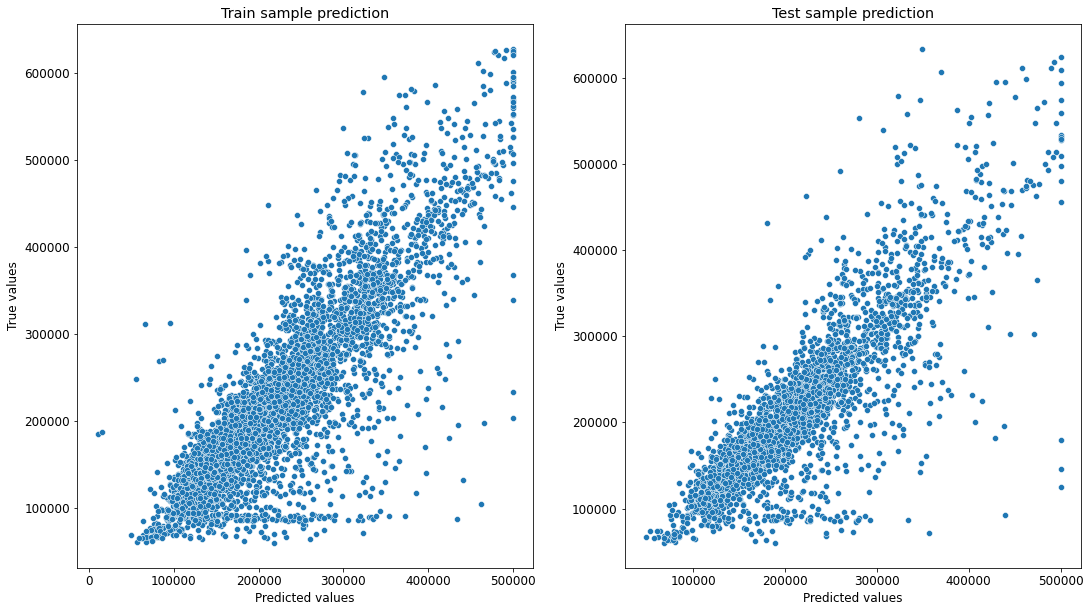

In [99]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

y_test_preds = lr_model.predict(X_test)
# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [100]:
X_test = df_test.loc[:,feature_names]
y_test_preds = lr_model.predict(X_test)
# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

df_test_csv = df_test
df_test['Price'] = y_test_preds  
df_test_csv = df_test.loc[:,['Id', 'Price']]
df_test_csv.head()

,Id,Price
0,725,139345.299600
1,15856,210150.029425
2,5480,77988.859839
3,15664,296622.643732
4,14275,145233.928958


In [101]:
df_test_csv.to_csv("SPevtsov_predictions.csv", sep=',', index=False)
df = pd.read_csv("SPevtsov_predictions.csv", ',')
df.head(5)

,Id,Price
0,725,139345.299600
1,15856,210150.029425
2,5480,77988.859839
3,15664,296622.643732
4,14275,145233.928958
